# This file is used to visualize the wrestler and metric dataframes.

In [1]:
import matplotlib as mpltlib
import matplotlib.pyplot as plt
import seaborn 
import datetime
import pandas as pd
import rank_helper
import numpy as np


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
df = pd.read_csv(f'tournaments_all_final.csv')

# remove empty tournaments 
df = df[df.Forfeit != 15.0]
upper = df[df.Rank.apply(lambda x: rank_helper.rank_is_top(x))]
div1 = upper[upper.Rank.apply(lambda x: rank_helper.divisions[rank_helper.long_rank(x)] >= 6)]
s = div1[div1.Rank.apply(lambda x: rank_helper.rank_is_sanyaku(x))]


In [8]:
stats_df = pd.read_csv(f'stats_by_id.csv')

# ONLY LOOKING AT MORE THAN 40 career wins!
stats_df = stats_df[stats_df.n > 40]

#stats_df['push_class'] = stats_df.apply(lambda row: pusher_class(row.m) )
for i, row in stats_df.iterrows():
    stats_df.at[i, 'push_class'] = push_class(row['m'])

    
stats_df.head(20)
stats_df.shape

(901, 5)

# Fitting a prediction model and Null Hypothesis

Another way of determining whether or not pushers are streaky is to make a prediction model with multiple variables and look at the relationship between all of the variables and see if it is any different from pushers and non-pushers. However, due note that it will be very hard to accurately predict expected wins for the sumo tournament, since there are lots of external factors that could affect the player's wins in a tournament that we don't have the data on (such as player injury, condition on that day, etc). Hopefully, we see a p-value < 0.05, so that we can show that all of the variables are somewhat correlated.

# Prepping the dataframe

In order to do our best effort on accurately predicting a player's expected wins based on their fields, we will include as much variables that we think that might affect the player's expected wins

* m-scores
* Division of the player
* Rank in the division
* Previous wins (in the tournament before)

and in order to use all these data in a model, we will need to do some prepping for the dataframe

In [49]:
# here we will prep the dataframe by separating the division and the rank from the rank column

# move this import to the first box later.
import statsmodels.formula.api as smf
# use this to shut the error off
pd.options.mode.chained_assignment = None


ranks = pd.DataFrame(full.Rank.apply(lambda x: rank_helper.full_rank(x)))
rank_list = ranks['Rank'].tolist() 
full[['div','ranked']] = pd.DataFrame(rank_list, index = ranks.index)
full.head()



,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked
1,1,1990-05-01,J10w,LWWWWWWWLLWLWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,8.0,Juryo,10
2,1,1990-07-01,J3e,WWWWLWLLWWLWWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,11.0,Juryo,3
3,1,1990-09-01,M14e,WWWLLWWWLWLLWWL,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,11.0,Maegashira,14
4,1,1990-11-01,M7w,WLWWLLLWWWLLWWW,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,7
5,1,1991-01-01,M1w,LWLLLWLWWWLWWWL,8-7,8.0,7.0,0.0,0.0,53.33,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,1


In [50]:
# rename column name of the streak, so that we can use it in the formula without error (parenthesis will confuse it)
full.rename({'Streak(Wins)': 'Streak'}, axis = 1, inplace = True)
full.head()

,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked
1,1,1990-05-01,J10w,LWWWWWWWLLWLWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,8.0,Juryo,10
2,1,1990-07-01,J3e,WWWWLWLLWWLWWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,11.0,Juryo,3
3,1,1990-09-01,M14e,WWWLLWWWLWLLWWL,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,11.0,Maegashira,14
4,1,1990-11-01,M7w,WLWWLLLWWWLLWWW,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,7
5,1,1991-01-01,M1w,LWLLLWLWWWLWWWL,8-7,8.0,7.0,0.0,0.0,53.33,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,1


# Fitting a prediction model for the pushers

Since we are dealing with pushers and non-pushers, it will be appropriate to create two prediction model, so that we can compare the difference between the two.

Like we have talked above, the major variables that we think that will affect the expected wins are

* m-score
* division
* rank in the division
* wins in previous tournament

so the equation of the regression will be:

*Expected Wins = m(x) + div(x) + rank(x) + prev_wins(x)*

In [105]:
# only include pushers
pushers = full.loc[full['push_class'] != 'Full other']
pushers = pushers.loc[pushers['push_class'] != 'Moderate other']
est2 = smf.ols(formula='Win ~ m + div + ranked + prev_wins', data = pushers).fit()
est2.summary()

# Juryo == dummy variable

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     13.98
Date:                Sun, 16 May 2021   Prob (F-statistic):           5.41e-18
Time:                        02:21:05   Log-Likelihood:                -8157.4
No. Observations:                3593   AIC:                         1.633e+04
Df Residuals:                    3585   BIC:                         1.638e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.4119      0.181     40.841      0.000       7.056       7.768
div[T.Komusubi]      -0.8588      0.238     -3.608      0.000      -1.325      -0.392
div[T.Maegashira]    -0.5906      0.085     -6.928      0.000      -0.758      -0.423
div[T.Ozeki]          0.7680      0.237      3.239      0.001       0.303       1.233
div[T.Sekiwake]       0.6011      0.230      2.614      0.009       0.150       1.052
m                    -0.1262      0.155     -0.813      0.416      -0.431       0.178
ranked                0.0329      0.010      3.369      0.001       0.014       0.052
prev_wins            -0.0366      0.018     -1.982      0.048      -0.073      -0.000
==============================================================================
Omnibus:                      120.406   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.193
Skew:                          -0.429   Prob(JB):                     2.67e-30
Kurtosis:                       3.418   Cond. No.                         73.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Uh oh

Every variables that we have put into the model is statistically significant: except for the m-score, which has a p value of 0.416. This does make sense, as we based off the classification with the m-score and since it's much higher than the 95% confidence level that we are aiming for, it will be better if we take the m-score off from the formula.

In [59]:
est2 = smf.ols(formula='Win ~ div + ranked + prev_wins', data = pushers).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     16.20
Date:                Sun, 16 May 2021   Prob (F-statistic):           1.75e-18
Time:                        01:26:33   Log-Likelihood:                -8157.7
No. Observations:                3593   AIC:                         1.633e+04
Df Residuals:                    3586   BIC:                         1.637e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.4673      0.168     44.405      0.000       7.138       7.797
div[T.Komusubi]      -0.8598      0.238     -3.613      0.000      -1.326      -0.393
div[T.Maegashira]    -0.5870      0.085     -6.896      0.000      -0.754      -0.420
div[T.Ozeki]          0.7781      0.237      3.287      0.001       0.314       1.242
div[T.Sekiwake]       0.5991      0.230      2.605      0.009       0.148       1.050
ranked                0.0322      0.010      3.310      0.001       0.013       0.051
prev_wins            -0.0368      0.018     -1.994      0.046      -0.073      -0.001
==============================================================================
Omnibus:                      120.181   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.868
Skew:                          -0.428   Prob(JB):                     3.14e-30
Kurtosis:                       3.417   Cond. No.                         73.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
est2.params

Intercept            7.467348
div[T.Komusubi]     -0.859820
div[T.Maegashira]   -0.587043
div[T.Ozeki]         0.778140
div[T.Sekiwake]      0.599068
ranked               0.032213
prev_wins           -0.036785
dtype: float64

Now that looks much better, as all of the p-values are < 0.05, which means that we can reject the null hypothesis that there are no relationship between wins and these variables. 

From the parameters that we got from the output, we can see that:

* The expected wins in *Juryo* division is 6.937122 (this is the **dummy** variable)
* If you are in *Komusubi* division, you will lose 0.859820 more games than people in *Juryo* division
* If you are in *Maegashira* division, you will lose 0.587043 more games than people in *Juryo* division
* If you are in *Ozeki* division, you will win 0.778140 more games than people in *Juryo* division
* If you are in *Sekiwake* division, you will win 0.599068 more games than people in *Juryo* division
* *Yokozuna* division is missing from this model, since most of the player in the *Yokozuna* division uses a lot of different technique
* As the *rank* in the division increases, the expected win increases by 0.0322
* As you have more *previous tournament wins*, the expected win decreases by 0.036785

# Fitting a prediction model for non-pushers

In [74]:
# only include non-pushers
non_pushers = full.loc[full['push_class'] != 'Full pusher']
non_pushers = non_pushers.loc[non_pushers['push_class'] != 'Moderate pusher']
est3 = smf.ols(formula='Win ~ div + ranked + prev_wins', data = non_pushers).fit()
est3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     332.1
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        01:35:35   Log-Likelihood:                -48254.
No. Observations:               20880   AIC:                         9.652e+04
Df Residuals:                   20872   BIC:                         9.659e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.8995      0.071     97.544      0.000       6.761       7.038
div[T.Komusubi]      -0.5826      0.097     -6.028      0.000      -0.772      -0.393
div[T.Maegashira]    -0.5596      0.037    -14.978      0.000      -0.633      -0.486
div[T.Ozeki]          1.6565      0.081     20.480      0.000       1.498       1.815
div[T.Sekiwake]       0.6492      0.097      6.722      0.000       0.460       0.838
div[T.Yokozuna]       3.1912      0.100     31.907      0.000       2.995       3.387
ranked                0.0332      0.004      7.892      0.000       0.025       0.041
prev_wins             0.0359      0.008      4.721      0.000       0.021       0.051
==============================================================================
Omnibus:                     1367.206   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1981.101
Skew:                          -0.561   Prob(JB):                         0.00
Kurtosis:                       4.009   Cond. No.                         74.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
est3.params

Intercept            6.899532
div[T.Komusubi]     -0.582600
div[T.Maegashira]   -0.559557
div[T.Ozeki]         1.656497
div[T.Sekiwake]      0.649159
div[T.Yokozuna]      3.191202
ranked               0.033187
prev_wins            0.035873
dtype: float64

# What can we see from the Model?

We can see that all of the p-values are less than zero, which means that this prediction model is more accurate than the one about the pushers. However, we do see a low R^2 value from both of the models.

From the parameters that we got from the output, we can see that:

* The expected wins in *Juryo* division is 6.899532 (this is the **dummy** variable)
* If you are in *Komusubi* division, you will lose 0.582600 more games than people in *Juryo* division
* If you are in *Maegashira* division, you will lose 0.559557 more games than people in *Juryo* division
* If you are in *Ozeki* division, you will win 1.656497 more games than people in *Juryo* division
* If you are in *Sekiwake* division, you will win 0.649159 more games than people in *Juryo* division
* If you are in *Yokozuna* division, you will win 3.191202 more games than people in *Juryo* division
* As the *rank* in the division increases, the expected win increases by 0.033187
* As you have more *previous tournament wins*, the expected win increases by 0.035873

# Is there any difference between the two model? What does it tell us?

As we can see from the parameters of the two models, we can clearly see that all the variables are pretty similar in values between the two models. However, we do see a change in correlation between previous tournament wins. In the pusher prediction model, we saw that as the previous tournament wins increased, the expected win decreased. However, in the non-pusher prediction model, we saw that as the previous tournament wins increased, the expected win increased. With this fact, we can guess that pushers tend to lose more games after winning a lot of games and non-pushers tend to win more games after winning a lot of games. This could also mean that non-pushers are a lot more stable at getting wins than the pushers. However, we cannot conclude with this fact, since our R^2 value is low

# How did our model do in regards of prediction?

Let's visualize how well did our prediction model do in regards of predicting a player's expected wins. In order to visualize it, we must first calculate the residual. We can calculate the residual by subtracting the actual value from the predicted value. But guessing from the low R^2 value that we have gotten from the prediction model, it is very likely that it is not going to be very accurate.

*residual = predicted - actual*

In [84]:
# helper function to predict the values for the pushers
def predict_p(m,div,ranked,prev_wins):
    d = [['',0,0]]
    f1 = pd.DataFrame(d, columns = ['div','ranked','prev_wins'])

    f1['div'].iat[0] = div
    f1['ranked'].iat[0] = ranked 
    f1['prev_wins'].iat[0] = prev_wins
    
    p = est2.predict(f1.loc[:,['div','ranked','prev_wins']])
    return p.iloc[0]

# helper function to predict the values for the non-pushers
def predict_o(m,div,ranked,prev_wins):
    d = [['',0,0]]
    f1 = pd.DataFrame(d, columns = ['div','ranked','prev_wins'])

    f1['div'].iat[0] = div
    f1['ranked'].iat[0] = ranked 
    f1['prev_wins'].iat[0] = prev_wins
    
    p = est3.predict(f1.loc[:,['div','ranked','prev_wins']])
    return p.iloc[0]

In [77]:
# we can use the prediction to calcualte the intercept for the pushers
predict_p(0,"Juryo",0,0)

7.467348360534286

In [81]:
# we can use the prediction to calculate the intercept
predict_o(0,"Juryo",0,0)

6.899532144575458

In [89]:
pushers['predict'] = est2.predict(pushers.loc[:,['div','ranked','prev_wins']])
pushers.head()

,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked,predict
512,8,1995-09-01,J12e,LWWWWLLWLLWWLLW,8-7,8.0,7.0,0.0,0.0,53.33,1,-0.71177,0.746442,773.0,Full pusher,8.0,Juryo,12,7.559624
513,8,1995-11-01,J10e,LWLLLLLWLWWLWLW,6-9,6.0,9.0,0.0,0.0,40.00,0,-0.71177,0.746442,773.0,Full pusher,8.0,Juryo,10,7.495198
514,8,1996-01-01,J12e,WWLLWLWLLWWWWLW,9-6,9.0,6.0,0.0,0.0,60.00,1,-0.71177,0.746442,773.0,Full pusher,6.0,Juryo,12,7.633193
515,8,1996-03-01,J9w,LLWWLLWWWLWLWLW,8-7,8.0,7.0,0.0,0.0,53.33,0,-0.71177,0.746442,773.0,Full pusher,9.0,Juryo,9,7.426201
516,8,1996-05-01,J6e,WLWWLLWWLWWLWLL,8-7,8.0,7.0,0.0,0.0,53.33,0,-0.71177,0.746442,773.0,Full pusher,8.0,Juryo,6,7.366347


In [120]:
pushers['residuals'] =  pushers['predict'] - pushers['Win']
pushers.head()

,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked,predict,residuals
332,6,1993-07-01,J5w,WWWLWWLWWWWLWWL,11-4,11.0,4.0,0.0,0.0,73.33,1,-0.009904,0.50361,554.0,Moderate pusher,9.0,Juryo,5,8.972193,-2.027807
333,6,1993-09-01,M15w,WWLLWWLLWLWLWWW,9-6,9.0,6.0,0.0,0.0,60.00,0,-0.009904,0.50361,554.0,Moderate pusher,11.0,Maegashira,15,5.818713,-3.181287
334,6,1993-11-01,M11w,LWLWWWLLWWWLWLW,9-6,9.0,6.0,0.0,0.0,60.00,0,-0.009904,0.50361,554.0,Moderate pusher,9.0,Maegashira,11,5.993431,-3.006569
335,6,1994-01-01,M3w,WLLWLLWWLWWWWWW,10-5,10.0,5.0,0.0,0.0,66.67,1,-0.009904,0.50361,554.0,Moderate pusher,9.0,Maegashira,3,8.972193,-1.027807
336,6,1994-03-01,S1w,WLLLLLWWWLWWWWW,9-6,9.0,6.0,0.0,0.0,60.00,1,-0.009904,0.50361,554.0,Moderate pusher,10.0,Sekiwake,1,8.997127,-0.002873


In [88]:
non_pushers['predict'] = est3.predict(non_pushers.loc[:,['div','ranked','prev_wins']])
non_pushers.head()

,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked,predict
1,1,1990-05-01,J10w,LWWWWWWWLLWLWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,8.0,Juryo,10,7.518388
2,1,1990-07-01,J3e,WWWWLWLLWWLWWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,11.0,Juryo,3,7.393695
3,1,1990-09-01,M14e,WWWLLWWWLWLLWWL,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,11.0,Maegashira,14,7.199199
4,1,1990-11-01,M7w,WLWWLLLWWWLLWWW,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,7,6.895142
5,1,1991-01-01,M1w,LWLLLWLWWWLWWWL,8-7,8.0,7.0,0.0,0.0,53.33,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,1,6.696018


In [92]:
non_pushers['residuals'] =  non_pushers['predict'] - non_pushers['Win']
non_pushers.head()

,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked,predict,residuals
1,1,1990-05-01,J10w,LWWWWWWWLLWLWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,8.0,Juryo,10,7.518388,-3.481612
2,1,1990-07-01,J3e,WWWWLWLLWWLWWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,11.0,Juryo,3,7.393695,-3.606305
3,1,1990-09-01,M14e,WWWLLWWWLWLLWWL,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,11.0,Maegashira,14,7.199199,-1.800801
4,1,1990-11-01,M7w,WLWWLLLWWWLLWWW,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,7,6.895142,-2.104858
5,1,1991-01-01,M1w,LWLLLWLWWWLWWWL,8-7,8.0,7.0,0.0,0.0,53.33,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,1,6.696018,-1.303982


[Text(0.5, 1.0, 'Previous tournament wins vs Residuals for pushers'),
 Text(0.5, 0, 'Previous tournament wins'),
 Text(0, 0.5, 'Residuals')]

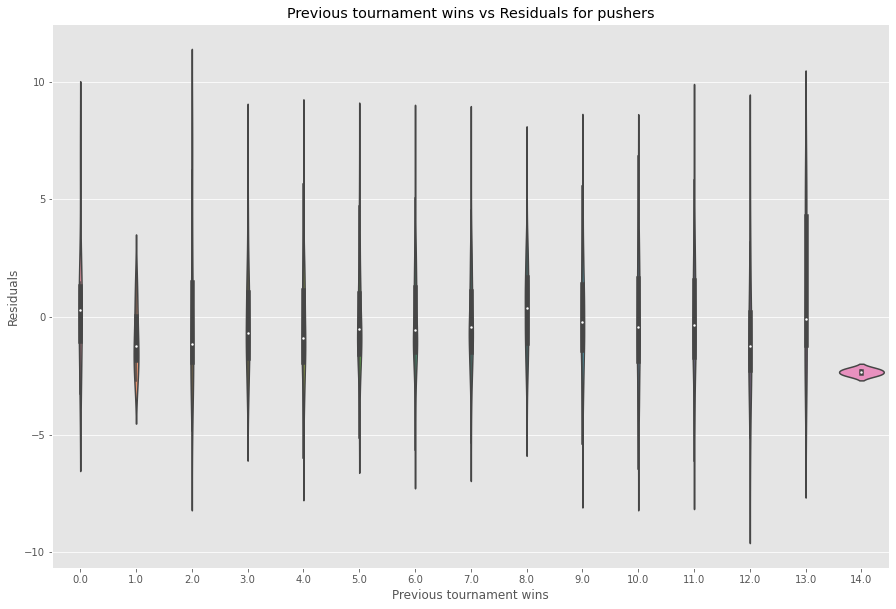

In [99]:
seaborn.violinplot(x="prev_wins",y='residuals', data = pushers).set(                   
                    title='Previous tournament wins vs Residuals for pushers',
                    xlabel='Previous tournament wins',
                    ylabel='Residuals')

[Text(0.5, 1.0, 'Previous tournament wins vs Residuals for non'),
 Text(0.5, 0, 'Previous tournament wins'),
 Text(0, 0.5, 'Residuals')]

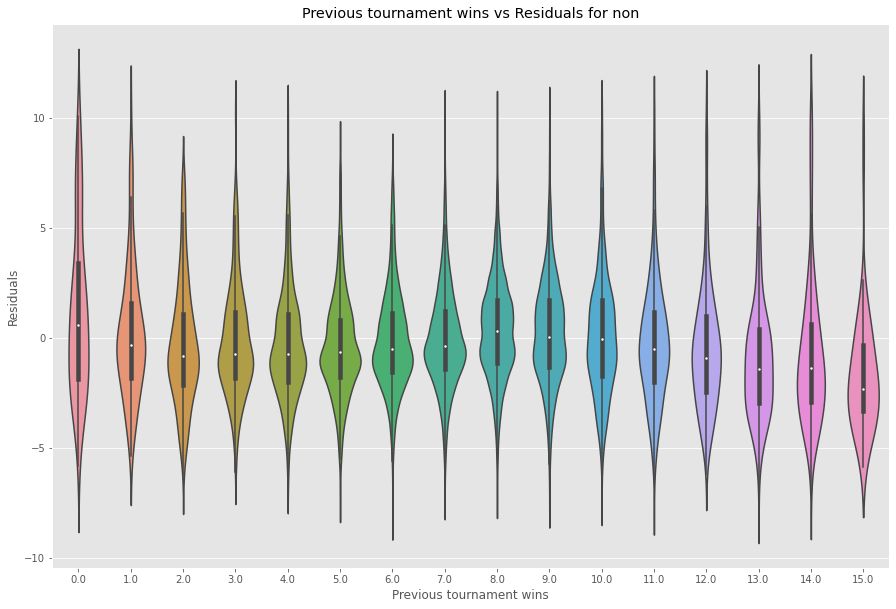

In [100]:
seaborn.violinplot(x="prev_wins",y='residuals', data = non_pushers).set(                   
                    title='Previous tournament wins vs Residuals for non',
                    xlabel='Previous tournament wins',
                    ylabel='Residuals')

# What can we see?

We can see that residuals are all over ther place when we plot previous tournament wins vs residuals for both of the model, which suggests that our prediction model is not as accurate as we wanted it to be when it comes to predicting expected wins based on previous tournament wins.

# Looking into the intra-tournament streak

Based on the residuals plots that we plotted, we found that our prediction model isn't as accurate that we wanted it to be, which is understandable as it is very hard to accurately guess the expected wins of a sumo tournament. But is there are better way to see if pushers are streaky? We believe that maybe we can predict the wins better if we fitted the intra-tournament streak into the model and remove all the other variables except for previous wins.

Unfortunately, during scraping, we changed the Streak data to 'Y' or 'N' instead of number of streaks, so that it is easier for the readers to understand whether the series had a win streak or not. In order to properly fit the linear model, we would need the actual number of streaks in a series, since number of streaks could affect the expected wins that a player should get from a series. Let's first recount the number of streaks in the series. A series has a streak when you win 4 games in a row, since the bouts(series) are out of 15 games, we would expect to have a player to have a maximum of 3 streaks.

For example, if a player were to have a series such as **WWWW**LWLLWWL**WWWW**, the series would have 2 streaks, since there are 2 instances of winning 4 games in row.

In [ ]:
import re
# We really should've kept the number of streaks in scraping, but this was my mistake lol
for index, row in full.iterrows():
    full.at[index,'Streak'] =sum(1 for x in re.finditer(r'W{4,}', row['Series']))
full

# Fitting a linear model and adding interaction term

The previous model that we have fitted didn't really perform well when we looked at the previous tournament vs residuals plot. Let's add an interaction term (intra-tournament streak) to see if we can improve the prediction by a little bit.

In [121]:
# include only pushers
est4 = smf.ols(formula='Win ~ prev_wins*Streak', data = pushers).fit()
est4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     568.4
Date:                Sun, 16 May 2021   Prob (F-statistic):          3.10e-302
Time:                        02:27:42   Log-Likelihood:                -7507.5
No. Observations:                3593   AIC:                         1.502e+04
Df Residuals:                    3589   BIC:                         1.505e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.7797      0.146     46.474      0.000       6.494       7.066
prev_wins           -0.0874      0.019     -4.600      0.000      -0.125      -0.050
Streak               1.9681      0.232      8.501      0.000       1.514       2.422
prev_wins:Streak     0.1123      0.030      3.747      0.000       0.054       0.171
==============================================================================
Omnibus:                      118.848   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.555
Skew:                          -0.440   Prob(JB):                     2.71e-29
Kurtosis:                       3.323   Cond. No.                         65.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
# include only non_pushers
est5 = smf.ols(formula='Win ~ prev_wins*Streak', data = non_pushers).fit()
est5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     4152.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        02:21:49   Log-Likelihood:                -44471.
No. Observations:               20880   AIC:                         8.895e+04
Df Residuals:                   20876   BIC:                         8.898e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.4080      0.063    102.162      0.000       6.285       6.531
prev_wins           -0.0389      0.008     -4.797      0.000      -0.055      -0.023
Streak               1.3249      0.093     14.260      0.000       1.143       1.507
prev_wins:Streak     0.2359      0.012     20.334      0.000       0.213       0.259
==============================================================================
Omnibus:                      377.494   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              398.291
Skew:                          -0.331   Prob(JB):                     3.25e-87
Kurtosis:                       3.136   Cond. No.                         65.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
est4.pvalues

Intercept           0.000000e+00
prev_wins           4.371999e-06
Streak              2.715647e-17
prev_wins:Streak    1.820821e-04
dtype: float64

In [116]:
est5.pvalues

Intercept           0.000000e+00
prev_wins           1.623313e-06
Streak              6.419753e-46
prev_wins:Streak    4.912964e-91
dtype: float64

# What can we see?

We can see that the pvalues for both of the model are close to zero and that the coefficient of the interaction from the non-pusher model is greater than the coefficient in the pusher model. This might suggest that the non-pushers tend to retain more of their win streaks than the pushers. We can also see that our R^2 value increased a bit.

# How accurate is it this time?

Let's find out

In [124]:
pushers_t = pushers
pushers_t['predict'] = est4.predict(pushers_t.loc[:,['prev_wins','Streak']])
pushers_t['residuals'] = pushers_t['predict'] - pushers_t['Win']
pushers_t.head()

,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked,predict,residuals
332,6,1993-07-01,J5w,WWWLWWLWWWWLWWL,11-4,11.0,4.0,0.0,0.0,73.33,1,-0.009904,0.50361,554.0,Moderate pusher,9.0,Juryo,5,8.972193,-2.027807
333,6,1993-09-01,M15w,WWLLWWLLWLWLWWW,9-6,9.0,6.0,0.0,0.0,60.00,0,-0.009904,0.50361,554.0,Moderate pusher,11.0,Maegashira,15,5.818713,-3.181287
334,6,1993-11-01,M11w,LWLWWWLLWWWLWLW,9-6,9.0,6.0,0.0,0.0,60.00,0,-0.009904,0.50361,554.0,Moderate pusher,9.0,Maegashira,11,5.993431,-3.006569
335,6,1994-01-01,M3w,WLLWLLWWLWWWWWW,10-5,10.0,5.0,0.0,0.0,66.67,1,-0.009904,0.50361,554.0,Moderate pusher,9.0,Maegashira,3,8.972193,-1.027807
336,6,1994-03-01,S1w,WLLLLLWWWLWWWWW,9-6,9.0,6.0,0.0,0.0,60.00,1,-0.009904,0.50361,554.0,Moderate pusher,10.0,Sekiwake,1,8.997127,-0.002873


In [123]:
non_pushers_t = non_pushers
non_pushers_t['predict'] = est5.predict(non_pushers_t.loc[:,['prev_wins','Streak']])
non_pushers_t['residuals'] = non_pushers_t['predict'] - non_pushers_t['Win']
non_pushers_t.head()

,id,Date,Rank,Series,W_L,Win,Loss,Forfeit,Absence,Winrate,Streak,m,p,n,push_class,prev_wins,div,ranked,predict,residuals
1,1,1990-05-01,J10w,LWWWWWWWLLWLWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,8.0,Juryo,10,9.308328,-1.691672
2,1,1990-07-01,J3e,WWWWLWLLWWLWWWW,11-4,11.0,4.0,0.0,0.0,73.33,1,0.027626,0.490066,604.0,Moderate other,11.0,Juryo,3,9.899139,-1.100861
3,1,1990-09-01,M14e,WWWLLWWWLWLLWWL,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,11.0,Maegashira,14,5.979678,-3.020322
4,1,1990-11-01,M7w,WLWWLLLWWWLLWWW,9-6,9.0,6.0,0.0,0.0,60.00,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,7,6.057549,-2.942451
5,1,1991-01-01,M1w,LWLLLWLWWWLWWWL,8-7,8.0,7.0,0.0,0.0,53.33,0,0.027626,0.490066,604.0,Moderate other,9.0,Maegashira,1,6.057549,-1.942451


[Text(0.5, 1.0, 'Previous tournament wins vs Residuals for pushers (with interaction term)'),
 Text(0.5, 0, 'Previous tournament wins'),
 Text(0, 0.5, 'Residuals')]

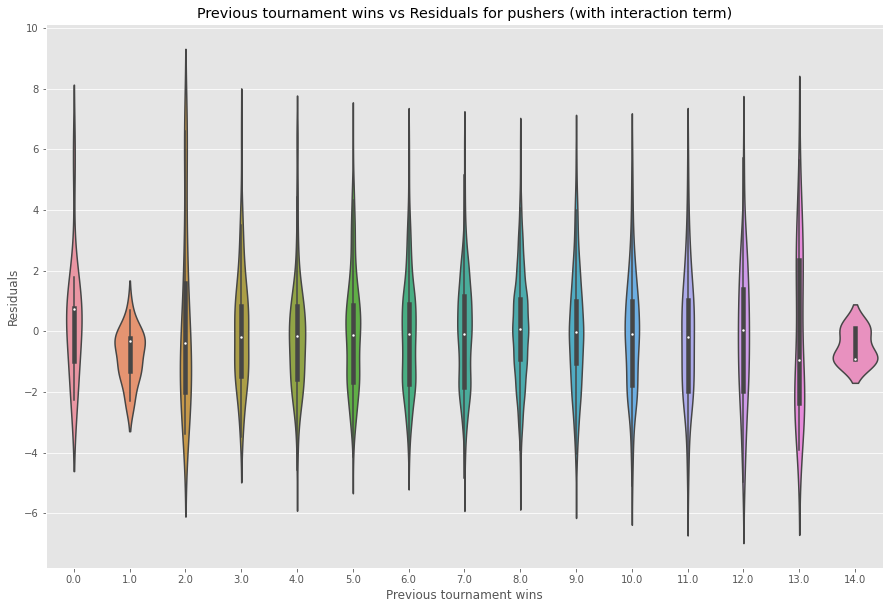

In [129]:
seaborn.violinplot(x="prev_wins",y='residuals', data = pushers_t).set(                   
                    title='Previous tournament wins vs Residuals for pushers (with interaction term)',
                    xlabel='Previous tournament wins',
                    ylabel='Residuals')

[Text(0.5, 1.0, 'Previous tournament wins vs Residuals for non-pushers (with interaction term)'),
 Text(0.5, 0, 'Previous tournament wins'),
 Text(0, 0.5, 'Residuals')]

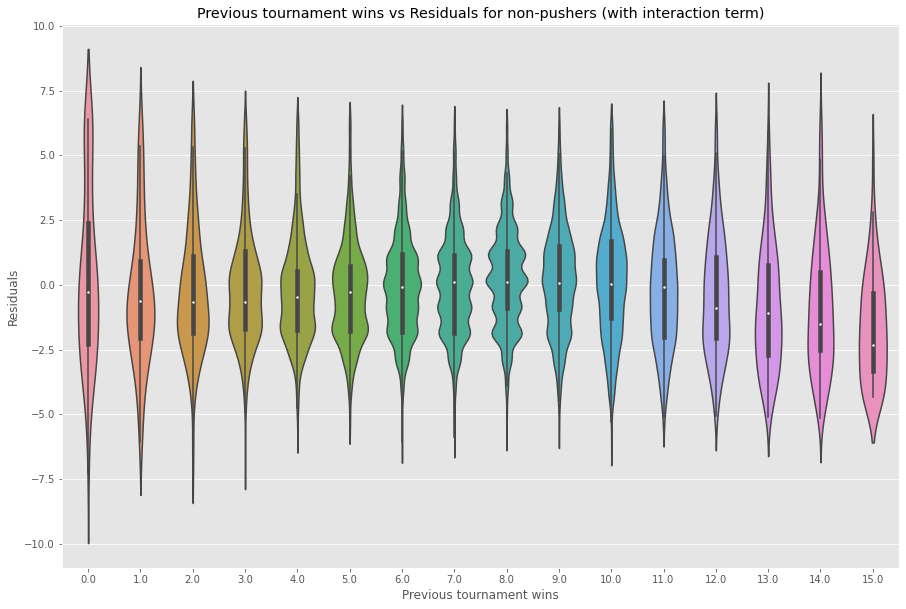

In [130]:
seaborn.violinplot(x="prev_wins",y='residuals', data = non_pushers_t).set(                   
                    title='Previous tournament wins vs Residuals for non-pushers (with interaction term)',
                    xlabel='Previous tournament wins',
                    ylabel='Residuals')

Compared to the first prediction model, we can see that this is little more accurate when we look at the residual graph.